In [1]:
import torch
from torch import nn
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np
import math
from torch.utils.data import Dataset, DataLoader
import pdb 
import time
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import warnings

In [2]:
class FramesDataset(Dataset):
    def text2Tensor(self, file_data):
        #process the file data such that it's a list of lists of offset tuple in each time step
        file_data_t = []
        data_temp = []
        try:
            frame_num = file_data[0][0]
        except IndexError:
            print("???:")
            print(file_data)
        traj_list = []
        frame_list = []
        for line in file_data:
            if frame_num != line[0]:
                frame_num = line[0]
                data_temp.sort(key=lambda data : data[1])
                file_data_t.append(data_temp)
                data_temp = [line]
            else:    
                data_temp.append(line)
            #keep a traj list for all trajs
            if line[1] not in traj_list:
                traj_list.append(line[1])
            if line[0] not in frame_list:
                frame_list.append(line[0])
        traj_list.sort()
        frame_list.sort()  
        
        #get participants in each frame
        #@note here the elements are ped's index in the traj list
        participants = [[] for i in range(len(file_data_t))]
        for frame_idx, line in enumerate(file_data_t):
            for traj_idx, traj in enumerate(traj_list):
                in_flag = False
                for data in line:
                    if data[1] == traj:
                        in_flag = True
                        participants[frame_idx].append(traj_list.index(data[1]))
                if not in_flag:
                    file_data_t[frame_idx].append([frame_list[frame_idx], traj, 0., 0.])
            file_data_t[frame_idx].sort(key=lambda data : data[1])

        file_data_tensors = torch.tensor(file_data_t, device=device)
        
        participant_masks = []
        for frame_idx, line in enumerate(participants):
            participant_masks.append([[torch.tensor(1.) if i in participants[frame_idx] else torch.tensor(0.) for i in range(len(traj_list))]])
        participant_masks = torch.tensor(participant_masks, device=device)
        
        return traj_list, participant_masks, file_data_tensors              
    
    
    '''
    @func preprocess
    @param path: relative path for the raw data
    @note raw data~ col1: frame index, col2: traj index, (col3, col4): (y, x)
    @return traj_list: indices for each trajactory in raw data
            participants_masks~tensor(frame num x traj num): indicate the presence of each ped at each frame
            file_data_tensors~tensor(frame num x traj num x 4): the position of each traj at each frame
                                                                if not present default to (0,0)
    '''
    def preprocess(self, path):
        #open the file as it is
        file_data = []
        with open(path, 'r') as file:
            for line in file:
                line_data = [int(float(data)) if i < 2 else float(data) for i, data in enumerate(line.rsplit())]
                line_data[2], line_data[3] = line_data[3], line_data[2]
                file_data.append(line_data)
        file_data = sorted(file_data, key=lambda data : data[1])
        file_data_sort = sorted(file_data, key=lambda data : data[0])
        
        traj_list, participant_masks, coord_tensors = self.text2Tensor(file_data_sort)
        
        #process the file data such that it contains the offsets not global coords
        file_data_off = []
        for i, line in enumerate(file_data):
            if i > 0:
                if file_data[i][1] == file_data[i-1][1]:
                    file_data_off.append([file_data[i][0], file_data[i][1], file_data[i][2]-file_data[i-1][2], file_data[i][3]-file_data[i-1][3]])
        file_data_off.sort(key=lambda data : data[0])        
        
        traj_list, participant_masks, off_tensors = self.text2Tensor(file_data_off)
        
        return traj_list, participant_masks, off_tensors, coord_tensors
    

    def __init__(self, path):
        self.traj_list, self.participant_masks, self.off_data, self.coord_data = self.preprocess(path)
        

    def __len__(self):
        return len(self.off_data)
    

    '''
    @note (X, Y) is a (file_data[idx], frame[idx+1]) pair if a single idx is provided
    a (frame[idx.start]2frame[idx.end], frame[idx.start+1]2frame[idx.end+1]) pair is provided
    if a index slice is provided
    the accompanying mask tensor follows the same rule 
    '''
    def __getitem__(self, idx):
        participant_mask = self.participant_masks[idx]
        X = self.off_data[idx]
        Z = torch.zeros(*X.shape)
        for coords in self.coord_data:
            if coords[0][0] == X[0][0]:
                Z = coords
        ret_data = {}
        ret_data["seq"] = X
        ret_data["mask"] = participant_mask
        ret_data["idx"] = idx
        ret_data["coords"] = Z
        return ret_data

    
    def getTrajList(self):
        return self.traj_list

    
    def getParticipants(self):
        return self.participant_mask
    
    
    def getCoordinates(self, seq):
        #get the coord data at the time step right before the seq starts
        before_coords = torch.empty(len(self.traj_list), 4, device=device)
        for x in seq:
            for i, coords in enumerate(self.coord_data):
                if coords[0][0] == x[0][0]:
                    before_coords = self.coord_data[i-1]
                    break
            break
        ret_data = torch.reshape(before_coords, (1, before_coords.shape[0], before_coords.shape[1])) 
        #get the rest
        for i, x in enumerate(seq):
            for j, coords in enumerate(self.coord_data):
                if coords[0][0] == x[0][0]:
                    coords_reshaped = torch.reshape(coords.clone(), (1, before_coords.shape[0], before_coords.shape[1]))                     
                    ret_data = torch.cat((ret_data, coords_reshaped), 0)
                    break
        return ret_data
    
    
    
    
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# D = FramesDataset("try_dataset.txt")
# Dloader = DataLoader(D, batch_size=20)

# for i, data in enumerate(Dloader):
#     if i == 0:
#         print(f"idx {data['idx']}")
#         print(f"X {data['seq'].shape}\n")
#         for i in data['seq']:
#             print(i)
#         print(f"mask\n {data['mask']}")
#         print(f"coords {data['coords'].shape}\n")   
#         for i in data['coords']:
#             print(i)       
#         print("\n\n\n\ntemp \n\n")
#         temp = D.getCoordinates(data['seq'])
#         for i in temp:
#             print(i)

In [3]:
class Phi(nn.Module):
    ''' a non-linear layer'''
    def __init__(self, dropout_prob):
        super(Phi, self).__init__()
        self.dropout_prob = dropout_prob
        self.ReLU = nn.ReLU()
        self.Dropout = nn.Dropout(p=dropout_prob)
    
    def forward(self, x):
        return self.Dropout(self.ReLU(x))


class VanillaLSTM(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=20, mediate_dim=10, output_dim=2, traj_num=3, dropout_prob=0.2):
        super(VanillaLSTM, self).__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.traj_num = traj_num
        self.InputLayer = nn.Linear(input_dim, mediate_dim)
        self.LSTMCell = nn.LSTMCell(mediate_dim, hidden_dim)
        self.OutputLayer = nn.Linear(hidden_dim, output_dim)
        self.Phi = Phi(dropout_prob=dropout_prob)


    def forward(self, X, part_masks, all_h_t, all_c_t, Y, T_obs, T_pred):
        outputs = torch.empty(X.shape[0], X.shape[1], self.output_dim, device=device)
        for frame_idx, x in enumerate(X):      
            if frame_idx <= T_obs or frame_idx > T_pred:
                outputs[frame_idx] = torch.zeros(X.shape[1], self.output_dim)
                continue

            r = self.Phi(self.InputLayer(x[:,2:]))
            all_h_t, all_c_t = self.LSTMCell(r, (all_h_t, all_c_t))
            part_mask = torch.t(part_masks[frame_idx]).expand(part_masks[frame_idx].shape[1], self.output_dim)
            outputs[frame_idx] = self.OutputLayer(all_h_t) * part_mask

            #dirty fix for appearance that's too short
            if frame_idx > 3 and frame_idx > T_obs:
                for traj_idx in torch.where(part_masks[frame_idx][0] != 0)[0]:
                    if part_masks[frame_idx-3][0][traj_idx] == 0:
                        outputs[frame_idx, traj_idx] = Y[frame_idx, traj_idx] 

        return outputs

In [4]:
def train(T_obs, T_pred, file, model=None, name="model"):
    tic = time.time()
    print(f"training on {file}")    
    
    h_dim = 1024
    batch_size = T_pred

    #try to train this
#     dataset = FramesDataset("crowds_zara02.txt")
    dataset = FramesDataset(file)
    #a dataloader for now not sure how to use
    dataloader = DataLoader(dataset, batch_size=batch_size)

    traj_num = len(dataset.getTrajList())
    h = torch.zeros(traj_num, h_dim, device=device)
    c = torch.zeros(traj_num, h_dim, device=device)

    if model == None:
        print("instantiating model")
        vl = VanillaLSTM(hidden_dim=h_dim, mediate_dim=128, output_dim=2, traj_num=traj_num)
    else:
        vl = model
    vl.to(device)

    #define loss & optimizer
    criterion = nn.MSELoss(reduction="sum")
    # criterion = Gaussian2DNll
    optimizer = torch.optim.Adagrad(vl.parameters(), weight_decay=0.0005)

    plot_data = [[] for _ in range(len(dataset) // batch_size)]
    #sequentially go over the dataset batch_size by batch_size
    EPOCH = 10
    for epoch in range(EPOCH):
        print(f"epoch {epoch+1}/{EPOCH}  ")
        for batch_idx, data in enumerate(dataloader):
            print(f"batch {batch_idx+1}/{len(dataset) // batch_size} ", end='\r')
            if batch_idx < len(dataset) // batch_size:
                Y = data['seq'][:T_pred][:T_pred,:,2:].clone()
                input_seq = data['seq'][:T_pred].clone()
                part_masks = data['mask']
                with torch.autograd.set_detect_anomaly(True):         
                    #forward prop
                    output = vl(input_seq, part_masks, h, c, Y, T_obs, T_pred)

                    #compute loss
                    Y_pred = output[T_obs+1:T_pred]
                    Y_g = Y[T_obs+1:T_pred]

                    cost = criterion(Y_pred, Y_g)

                    if epoch % 10 == 9:
                        print(epoch, batch_idx, cost.item())

                    #save data for plotting
                    plot_data[batch_idx].append(cost.item())

                    #backward prop
                    optimizer.zero_grad()
                    cost.backward()
                    optimizer.step()

    toc = time.time()
    print(f"training consumed {toc-tic}")

    #plot the cost
    plt.figure()
    for data in plot_data:
        plt.plot(np.arange(len(plot_data[0])), data)
    
    #save the model
    torch.save(vl, name)
    print(f"saved model in {name}\n")    

    return vl

In [5]:
def trajTruncate(coords, Y, part_mask, ratio=0.6):
    #count appearance
    for traj in range(coords.shape[1]):
        count = 0
        for t in range(part_mask.shape[0]):
            if part_mask[t][0][traj] != 0:
                count += 1
        if count < part_mask.shape[0]*ratio:
#             for t in range(coords.shape[0]):
#                 coords[t][traj][2:] *= 0.
            for t in range(Y.shape[0]):
                Y[t][traj] *= 0.
    
    return coords, Y

In [6]:
def validate(model, T_obs, T_pred, file):
    #try to validate this
    h_dim = 1024

    batch_size = T_pred

#     dataset = FramesDataset("crowds_zara02.txt")
    dataset = FramesDataset(file)    
    #a dataloader for now not sure how to use
    dataloader = DataLoader(dataset, batch_size=batch_size)

    traj_num = len(dataset.getTrajList())
    h = torch.zeros(traj_num, h_dim, device=device)
    c = torch.zeros(traj_num, h_dim, device=device)
    
    plotting_batches = np.arange(5)
    plotting_data = []
    avgDispErrMeans = []
    finalDispErrMeans = []    
    #validate the model based on the dataset
    print(f"validating on {file}")
    for batch_idx, data in enumerate(dataloader):
        if batch_idx < len(dataset) // batch_size:
            Y = data['seq'][:T_pred,:,2:].clone()
            input_seq = data['seq'][:T_pred].clone()
            part_masks = data['mask']            
            with torch.no_grad():         
                print(f"batch {batch_idx+1}/{len(dataset) // batch_size}  ", end='\r')
                #forward prop
                output = model(input_seq, part_masks, h, c, Y, T_obs, T_pred)

                #compute cost
                Y_pred = output[T_obs+1:T_pred]
                Y_g = Y[T_obs+1:T_pred]
                #......

                #get and process result                
                Y_g_param = Y_pred.clone()
                coords_param = dataset.getCoordinates(data['seq']).clone()

                #dirty truncate
                coords_param, Y_pred = trajTruncate(coords_param, Y_pred, part_masks, ratio=0.6)

                #save plotting data for visualization
                if batch_idx in plotting_batches:
                    plotting_data.append((Y_pred, part_masks, traj_num, batch_idx, dataset.getCoordinates(data['seq']), T_obs))

                if batch_idx in range(len(dataset) // batch_size-1):
                    err = avgDispError(Y_pred, part_masks, traj_num, batch_idx, dataset.getCoordinates(data['seq']), T_obs)
                    avgDispErrMeans.append(err)

                if batch_idx in range(len(dataset) // batch_size-1):
                    err = finalDispError(Y_pred, part_masks, traj_num, batch_idx, dataset.getCoordinates(data['seq']), T_obs)
                    finalDispErrMeans.append(err)                
        
    for d in plotting_data:
        plotting_batch(*d)
        
    print("total avg disp mean ", np.sum(np.array(avgDispErrMeans))/len([v for v in avgDispErrMeans if v != 0]))
    print("total final disp mean ", np.sum(np.array(finalDispErrMeans))/len([v for v in finalDispErrMeans if v != 0]))    

In [7]:
'''
@param trajs~(frame_num of a batch x traj_num x 2)
'''
def plotting_batch(batch_trajs_pred_gpu, part_masks, traj_num, batch_idx, coord_data, T_obs):          
    #reform the trajs tensor to a list of each traj's pos at each frame
    batch_trajs_pred = batch_trajs_pred_gpu.cpu().data.numpy()
    trajs_pred_list = [np.array([]) for _ in range(traj_num)]
    parts = []
    for frame_idx, trajs_pred in enumerate(batch_trajs_pred):
        for traj_idx, pos_pred in enumerate(trajs_pred):
            if not (pos_pred == np.array([0., 0.])).all():
                if traj_idx not in parts:
                    parts.append(traj_idx)
                    trajs_pred_list[int(traj_idx)] = np.array(pos_pred)  
                else:
                    trajs_pred_list[int(traj_idx)] = np.vstack((trajs_pred_list[int(traj_idx)], pos_pred))
            
    #calc the coords of each step for plotting
    batch_coords = coord_data.cpu().data.numpy()
    split_points = np.array(batch_coords[T_obs+1,:,2:])    
    trajs_pred_coords = []
    for traj_idx, traj in enumerate(trajs_pred_list):
        traj_pred_coord = np.array(split_points[traj_idx])
        temp_point = np.array(split_points[traj_idx])
        for off in traj:
            next_point = temp_point + off
            traj_pred_coord = np.vstack((traj_pred_coord, next_point))
            temp_point = next_point
        trajs_pred_coords.append(traj_pred_coord)
        
    #plot
    plt.figure(figsize=(12,12))
    plot_idx = 0
    for traj_idx in parts:
        try:
            pred_x = trajs_pred_coords[traj_idx][:,0]
        except IndexError:
            print("not enough appearance")
            continue
        pred_y = trajs_pred_coords[traj_idx][:,1]            
        plt.plot(pred_x, pred_y, label="pred"+str(traj_idx), marker=".")
        for i, (x, y) in enumerate(zip(pred_x, pred_y)):
            if i < len(pred_x)-1:
                plt.arrow(x, y, (pred_x[i+1] - x)/2, (pred_y[i+1] - y)/2, width=0.0001, head_width=0.001, head_length=0.001)            

        total_x = batch_coords[:,traj_idx,2]        
        total_x = total_x[np.where(total_x != 0.)]
        total_y = batch_coords[:,traj_idx,3]
        total_y = total_y[np.where(total_y != 0.)]       
        try:
            plt.plot(total_x, total_y, linestyle="dashed", label="total"+str(traj_idx), marker=".")
        except ValueError:
            print("plot error")
            
        for i, (x, y) in enumerate(zip(total_x, total_y)):
            if i < len(total_x)-1:
                plt.arrow(x, y, (total_x[i+1] - x)/2, (total_y[i+1] - y)/2, width=0.0001, head_width=0.001, head_length=0.001)
        plot_idx += 1
 
    plt.legend(loc="upper right")
    plt.title(f"batch {batch_idx}")
    
    
def avgDispError(batch_trajs_pred_gpu, part_masks, traj_num, batch_idx, coord_data, T_obs):
    #reform the trajs tensor to a list of each traj's pos at each frame
    batch_trajs_pred = batch_trajs_pred_gpu.cpu().data.numpy()
    trajs_pred_list = [np.array([]) for _ in range(traj_num)]
    parts = []
    for frame_idx, trajs_pred in enumerate(batch_trajs_pred):
        for traj_idx, pos_pred in enumerate(trajs_pred):
            if not (pos_pred == np.array([0., 0.])).all():
                if traj_idx not in parts:
                    parts.append(traj_idx)
                    trajs_pred_list[int(traj_idx)] = np.array(pos_pred)  
                else:
                    trajs_pred_list[int(traj_idx)] = np.vstack((trajs_pred_list[int(traj_idx)], pos_pred))
            
    #calc the coords of each step
    batch_coords = coord_data.cpu().data.numpy()
    split_points = np.array(batch_coords[T_obs+1,:,2:])    
    trajs_pred_coords = []
    for traj_idx, traj in enumerate(trajs_pred_list):
        traj_pred_coord = np.array(split_points[traj_idx])
        temp_point = np.array(split_points[traj_idx])
        for off in traj:
            next_point = temp_point + off
            traj_pred_coord = np.vstack((traj_pred_coord, next_point))
            temp_point = next_point
        trajs_pred_coords.append(traj_pred_coord)   
        
    
    #compare
    trajs_dist = []
    step_num = 0
    for traj_idx, traj in enumerate(parts):
        T_valid = T_obs+1+trajs_pred_coords[traj].shape[0]
        diff = batch_coords[T_obs+1:T_valid,traj,2:] - trajs_pred_coords[traj]
        traj_dist = np.sum(np.linalg.norm(diff, axis=1))        
        if not math.isnan(traj_dist):
            trajs_dist.append(traj_dist)
            step_num += diff.shape[0]

    if len(trajs_dist) != 0:
        mean_of_trajs_mean = np.sum(np.array(trajs_dist))/step_num
    else:
        mean_of_trajs_mean = 0
 
    print(f"avgDispError {mean_of_trajs_mean}")
    return mean_of_trajs_mean


def finalDispError(batch_trajs_pred_gpu, part_masks, traj_num, batch_idx, coord_data, T_obs):
    #reform the trajs tensor to a list of each traj's pos at each frame
    batch_trajs_pred = batch_trajs_pred_gpu.cpu().data.numpy()
    trajs_pred_list = [np.array([]) for _ in range(traj_num)]
    parts = []
    for frame_idx, trajs_pred in enumerate(batch_trajs_pred):
        for traj_idx, pos_pred in enumerate(trajs_pred):
            if not (pos_pred == np.array([0., 0.])).all():
                if traj_idx not in parts:
                    parts.append(traj_idx)
                    trajs_pred_list[int(traj_idx)] = np.array(pos_pred)  
                else:
                    trajs_pred_list[int(traj_idx)] = np.vstack((trajs_pred_list[int(traj_idx)], pos_pred))
            
    #calc the coords of each step
    batch_coords = coord_data.cpu().data.numpy()
    split_points = np.array(batch_coords[T_obs+1,:,2:])    
    trajs_pred_coords = []
    for traj_idx, traj in enumerate(trajs_pred_list):
        traj_pred_coord = np.array(split_points[traj_idx])
        temp_point = np.array(split_points[traj_idx])
        for off in traj:
            next_point = temp_point + off
            traj_pred_coord = np.vstack((traj_pred_coord, next_point))
            temp_point = next_point
        trajs_pred_coords.append(traj_pred_coord)   
        
    
    #compare
    trajs_dist = []
    for traj_idx, traj in enumerate(parts):
        T_valid = T_obs+1+trajs_pred_coords[traj].shape[0]
        diff = batch_coords[T_obs+1:T_valid,traj,2:] - trajs_pred_coords[traj]
        final_diff = diff[-1]
        traj_dist = np.linalg.norm(final_diff)       
        if not math.isnan(traj_dist):
            trajs_dist.append(traj_dist)

    if len(trajs_dist) != 0:
        mean_of_trajs_final = np.mean(np.array(trajs_dist))
    else:
        mean_of_trajs_final = 0
 
    print(f"finalDispError {mean_of_trajs_final}")
    return mean_of_trajs_final

device cuda:0

loading from eth_vl.pt
pulling from dir datasets/eth/test
validating on datasets/eth/test/biwi_eth.txt
avgDispError 0.47126324971516925
finalDispError 0.8645451664924622
avgDispError 0.3571280202557964
finalDispError 0.7159355282783508
avgDispError 1.126304817199707
finalDispError 2.179145574569702
avgDispError 0.3404876708984375
finalDispError 0.6469252705574036
avgDispError 0
finalDispError 0
avgDispError 0.9223620096842448
finalDispError 1.8191556930541992
avgDispError 0.9527272243125766
finalDispError 1.9175056219100952
avgDispError 0.09419555962085724
finalDispError 0.13271470367908478
avgDispError 0.2813400941736558
finalDispError 0.635031521320343
avgDispError 1.236325437372381
finalDispError 2.71456241607666
avgDispError 0.7840635299682617
finalDispError 1.5652395486831665
avgDispError 0.9385537599262438
finalDispError 1.5587033033370972
avgDispError 0.6638002991676331
finalDispError 1.273656964302063
avgDispError 0.7814559936523438
finalDispError 1.3337528705596

No handles with labels found to put in legend.


total avg disp mean  0.7175077087790762
total final disp mean  1.3978475295962431


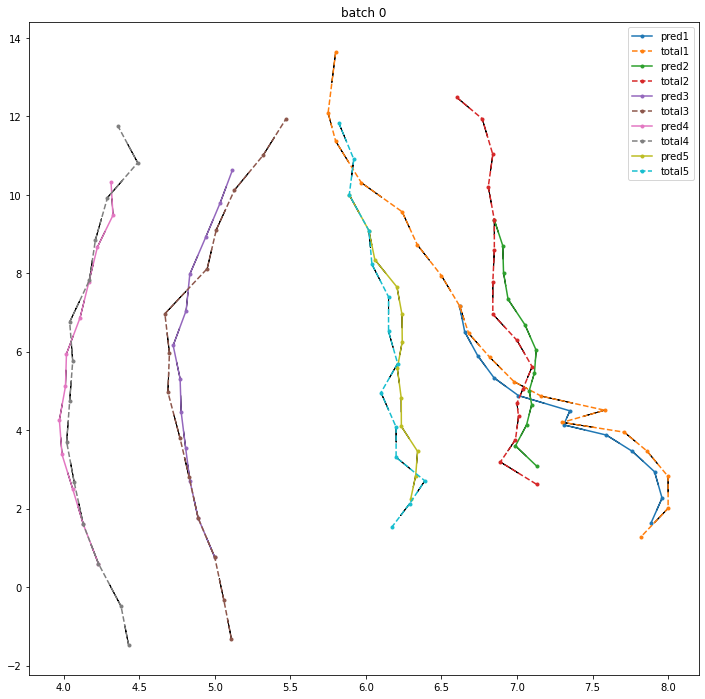

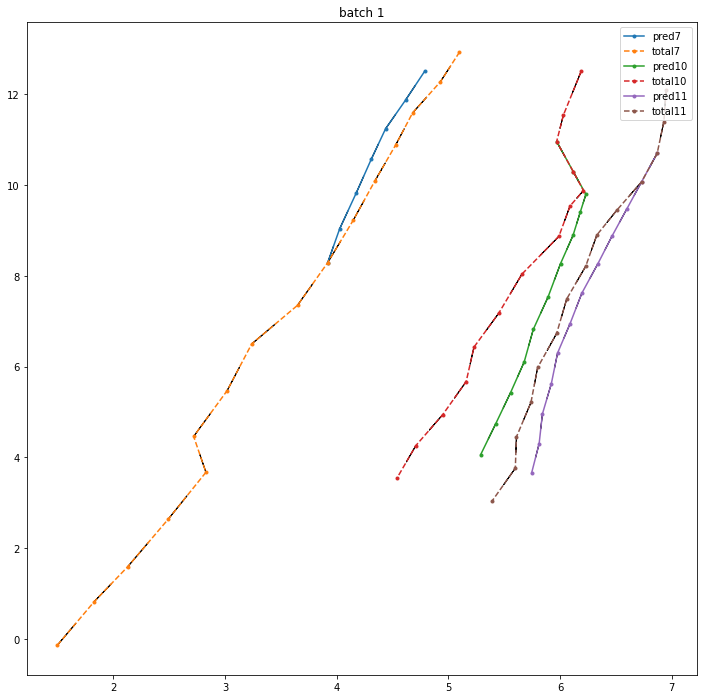

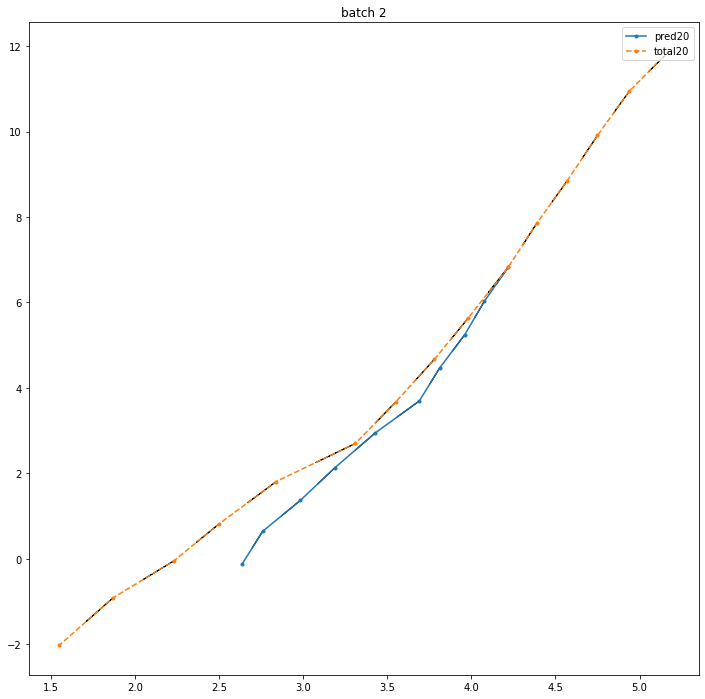

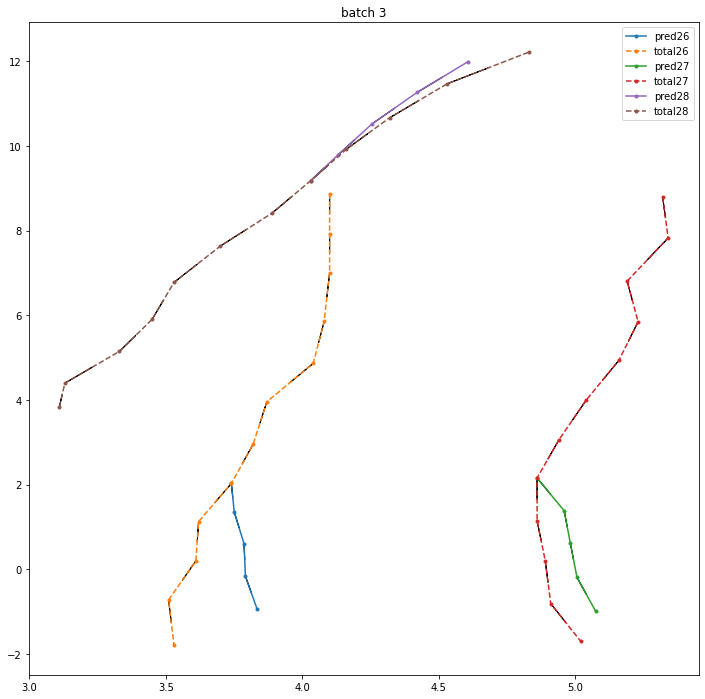

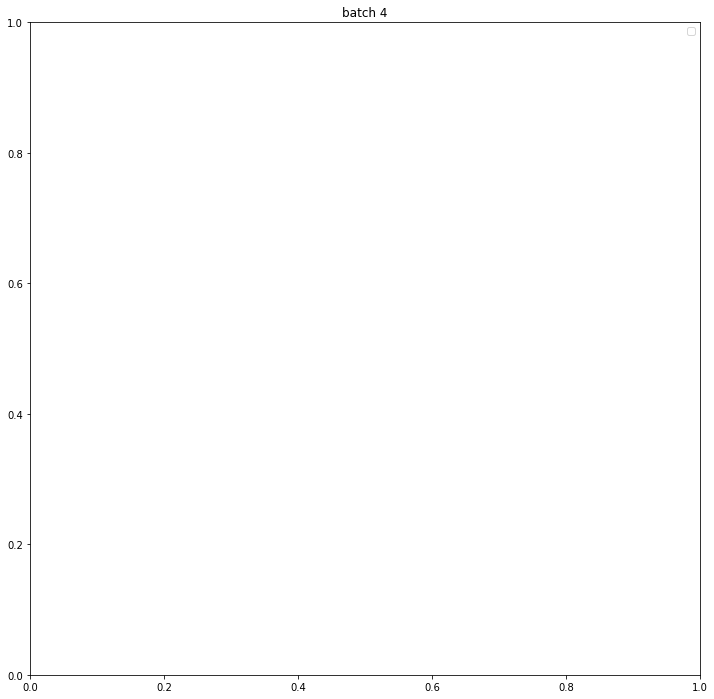

In [8]:
if __name__ == "__main__":
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"device {device}\n") 

#     train_datasets = ["datasets/eth/train",
#                       "datasets/hotel/train",               
#                       "datasets/univ/train",
#                       "datasets/zara1/train",
#                       "datasets/zara2/train"
#                      ]
#     val_datasets = ["datasets/eth/test",
#                     "datasets/hotel/test",               
#                     "datasets/univ/test",
#                     "datasets/zara1/test",
#                     "datasets/zara2/test"
#                     ]
#     names = ["eth_vl.pt",
#              "hotel_vl.pt",
#              "univ_vl.pt",
#              "zara1_vl.pt",
#              "zara2_vl.pt"
#             ]
    
#     for train_dataset, val_dataset, name in zip(train_datasets, val_datasets, names):
#         #preparing training set
#         files_dir = train_dataset
#         print(f"pulling from dir {files_dir}")
#         files = [join(files_dir, f) for f in listdir(files_dir) if isfile(join(files_dir, f))]
#         vl = None
#         #training
#         for file in files:
#             vl = train(8, 20, file, model=vl, name=name)

#         vl1 = torch.load(name)
#         print(f"loading from {name}")
#     #     validate(vl1, 8, 20, "try_dataset.txt")       
#         #preparing validating set
#         files_dir = val_dataset
#         print(f"pulling from dir {files_dir}")        
#         files = [join(files_dir, f) for f in listdir(files_dir) if isfile(join(files_dir, f))]
#         #validating
#         for file in files:
#             validate(vl1, 8, 20, file)   
            
#         print("====================================")

#     files_dir = "datasets/eth/train"
#     name = "eth_vl.pt"
#     print(f"pulling from dir {files_dir}")
#     files = [join(files_dir, f) for f in listdir(files_dir) if isfile(join(files_dir, f))]
#     vl = None
#     #training
#     for file in files:
#         vl = train(8, 20, file, model=vl, name=name)

    torch.cuda.empty_cache()
    vl1 = torch.load("eth_vl.pt")
    print(f"loading from eth_vl.pt")
#     validate(vl1, 8, 20, "try_dataset.txt")       
    #preparing validating set
    files_dir = "datasets/eth/test"
    print(f"pulling from dir {files_dir}")        
    files = [join(files_dir, f) for f in listdir(files_dir) if isfile(join(files_dir, f))]
    #validating
    for file in files:
        validate(vl1, 8, 20, file) 